#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the Encoder, and the Decoder.
Let's start by the Encoder that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. Specifically, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[To complete]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.


In [ ]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        #[TO COMPLETE] compute and return z
        z_mean = inputs[0]
        z_log_var = inputs[1]
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        eps = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(z_log_var/2)*eps
        return z

##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW5), and then use the obtained encoding to compute z_mean and z_var, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the latent_dim (that is the dimension of $z$) to 2. This choice is made to make possible to represent the results easily.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model z_mean and z_var. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. (Insert motivations about your choice into cells immediately below this one.)

---
>**CHOICE OF ARCHITECTURE**
---
I will write the discussion in the Exercise 6.3 since the architecture I chose for the decoder and encoder are totally related.

In [ ]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))
#[TO COMPLETE]
x = tf.keras.layers.Dense(512, activation="relu")(encoder_inputs)
x = tf.keras.layers.Dense(248, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)

#...[TO COMPLETE]...
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x) #[TO COMPLETE] Hint: size would be = latent_dim
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x) #[TO COMPLETE] Hint: size would be = latent_dim
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512)          401920      input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 248)          127224      dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 128)          31872       dense_7[0][0]                    
____________________________________________________________________________________________

##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. 2 layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer).

---
>**CHOICE OF ARCHITECTURE**
---
I chose to put 3 dense layers plus the ones of the latent space (mean and var) on the encoder and 3 layers on the decoder as the exercise proposes, with specular architecture.

I tried to vary the number and size of layers, from 16-32 units in each layer with only 2 layers on the encoder to 512-248-128. I found this last one to be the better result. On the output layer I choose sigmoid, as the output of each neuron must be between 0 and 1 (the value of each pixel). Any bounded activation function whose image is [0,1] would have been suitable (tanh for example). For the hidden layers, I chose ReLU but also tried adding layers with linear, sigmoid or tanh. The motivation for ReLU was that the model performed better with it than with linear or other, seemed to learn faster.

---
**CORRECTED ARCHITECTURE**

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(128, activation="relu")(latent_inputs) #[TO COMPLETE]
x = tf.keras.layers.Dense(248, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)

#...[TO COMPLETE]...
decoder_outputs = tf.keras.layers.Dense(784, activation="sigmoid" )(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_10 (Dense)             (None, 248)               31992     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               127488    
_________________________________________________________________
dense_12 (Dense)             (None, 784)               402192    
Total params: 562,056
Trainable params: 562,056
Non-trainable params: 0
_________________________________________________________________


##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

---
**CORRECTED**

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            #...[TO COMPLETE]...
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction))
                )
            #kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            #kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            #kl_loss = -0.5 * keras.backend.sum(1.0 + z_var - keras.backend.square(z_mean) - keras.backend.exp(z_var), axis=1)
            
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                ((1 + z_var) - tf.square(z_mean) - tf.exp(z_var)), axis = 1))

            # Not multipling in KL loss by 784 as advised in the correction because it is constant
            # and I already tried the models without that constant, so like this I can compare the losses.

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 9s 21ms/step - loss: 32.5416 - reconstruction_loss: 31.8660 - kl_loss: 0.6755
Epoch 2/30
391/391 [==============================] - 8s 21ms/step - loss: 31.3206 - reconstruction_loss: 29.9849 - kl_loss: 1.3358
Epoch 3/30
391/391 [==============================] - 8s 21ms/step - loss: 30.8440 - reconstruction_loss: 29.1472 - kl_loss: 1.6968
Epoch 4/30
391/391 [==============================] - 8s 21ms/step - loss: 30.2740 - reconstruction_loss: 28.1637 - kl_loss: 2.1103
Epoch 5/30
391/391 [==============================] - 8s 21ms/step - loss: 29.3985 - reconstruction_loss: 26.6765 - kl_loss: 2.7220
Epoch 6/30
391/391 [==============================] - 8s 21ms/step - loss: 29.0603 - reconstruction_loss: 26.1205 - kl_loss: 2.9397
Epoch 7/30
391/391 [==============================] - 8s 21ms/step - loss: 28.8881 - reconstruction_loss: 25.8348 - kl_loss: 3.0532
Epoch 8/30
391/391 [==============================] - 8s 21ms/step - loss: 2

---
> **MODEL TESTING**
---

- **MODEL 0**

128-64 ReLU:

loss: 28.0565 - reconstruction_loss: 24.3913 - kl_loss: 3.6652

---
- **MODEL 1** 

256-128 ReLU:

loss: 27.6813 - reconstruction_loss: 23.7844 - kl_loss: 3.8969

---

- **MODEL 2**

256-128 ReLU, first layer with sigmoid:

loss: 27.6309 - reconstruction_loss: 23.7216 - kl_loss: 3.9093

---

- **MODEL 3**

256-128 ReLU - Sigmoid in both encoder and decoder hidden

loss: 27.4323 - reconstruction_loss: 23.4679 - kl_loss: 3.9644

---

- **MODEL 4**

256-128-64 ReLU ReLU Sigmoid

loss: 27.3954 - reconstruction_loss: 23.4040 - kl_loss: 3.9914

---

- **MODEL 5**

256-128-64 ReLU x3

loss: 27.3769 - reconstruction_loss: 23.3111 - kl_loss: 4.0657

---

- **MODEL 6**

128-64-16 ReLU x3

loss: 28.0646 - reconstruction_loss: 24.3487 - kl_loss: 3.7160

---

- **MODEL 7**

64-32-16 ReLU x3

loss: 28.3361 - reconstruction_loss: 24.8544 - kl_loss: 3.4817

---

- **MODEL 8**

32-16 ReLU x2

loss: 29.0246 - reconstruction_loss: 25.9679 - kl_loss: 3.0566

---

- **MODEL 9**

512-256-128 Relu x3

loss: 27.4863 - reconstruction_loss: 23.4868 - kl_loss: 3.9995

---

- **MODEL 10**

512-256-128 ReLU x2 Tanh
loss: 27.2114 - reconstruction_loss: 22.8925 - kl_loss: 4.3189

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

In [ ]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

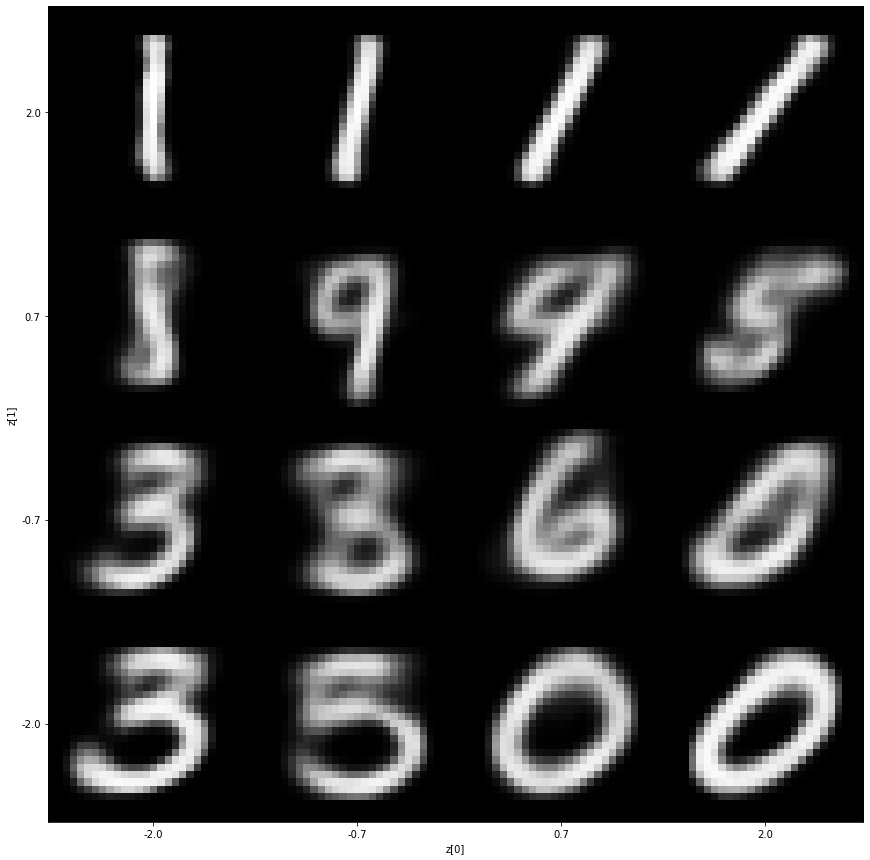

In [ ]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 4) # Model 6

#[TO COMPLETE] explore with different "scale"
# I had the different scales and different grids for the models I tried below

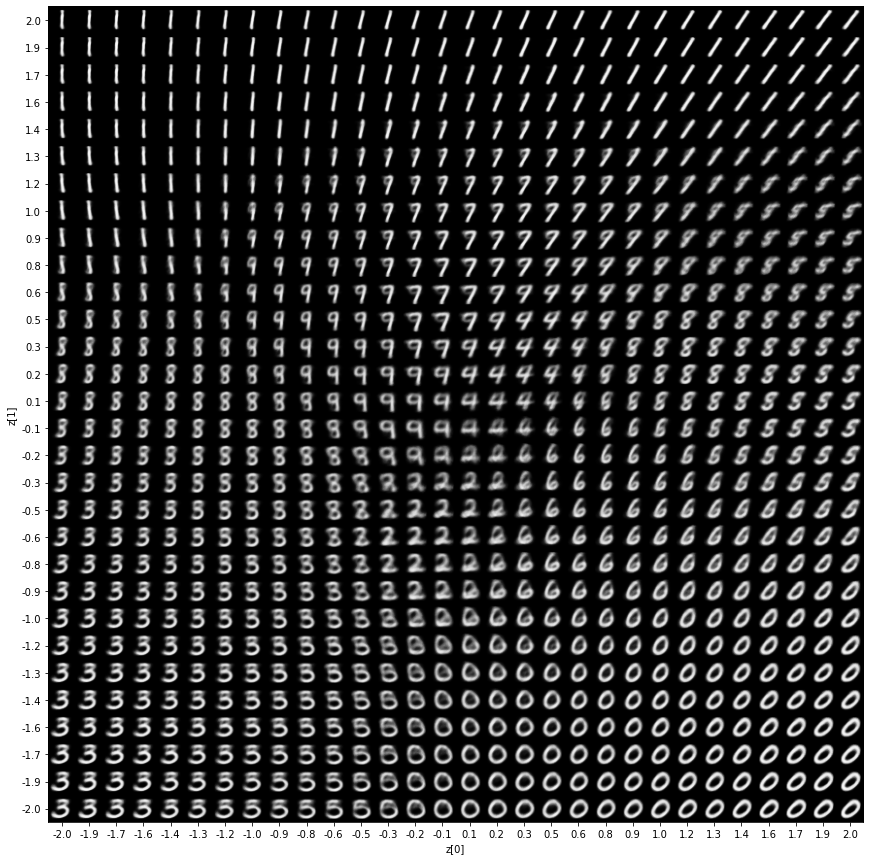

In [ ]:
plot_latent(encoder, decoder, 2.0, 30) # Model 6

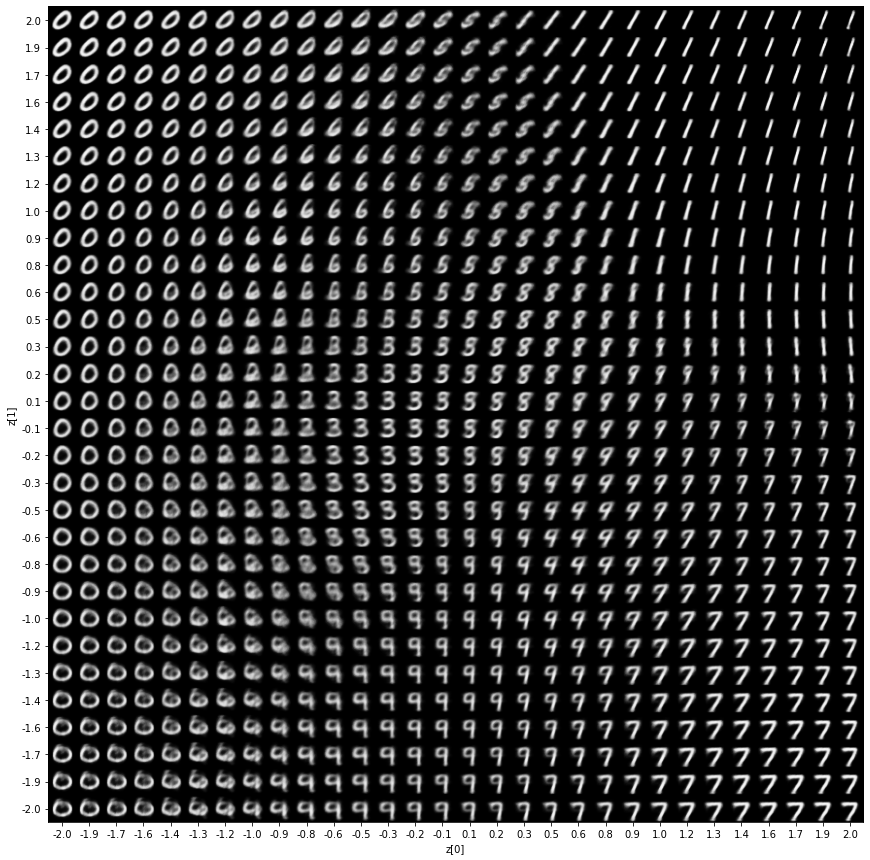

In [ ]:
plot_latent(encoder, decoder, 2.0, 30) # Model 7

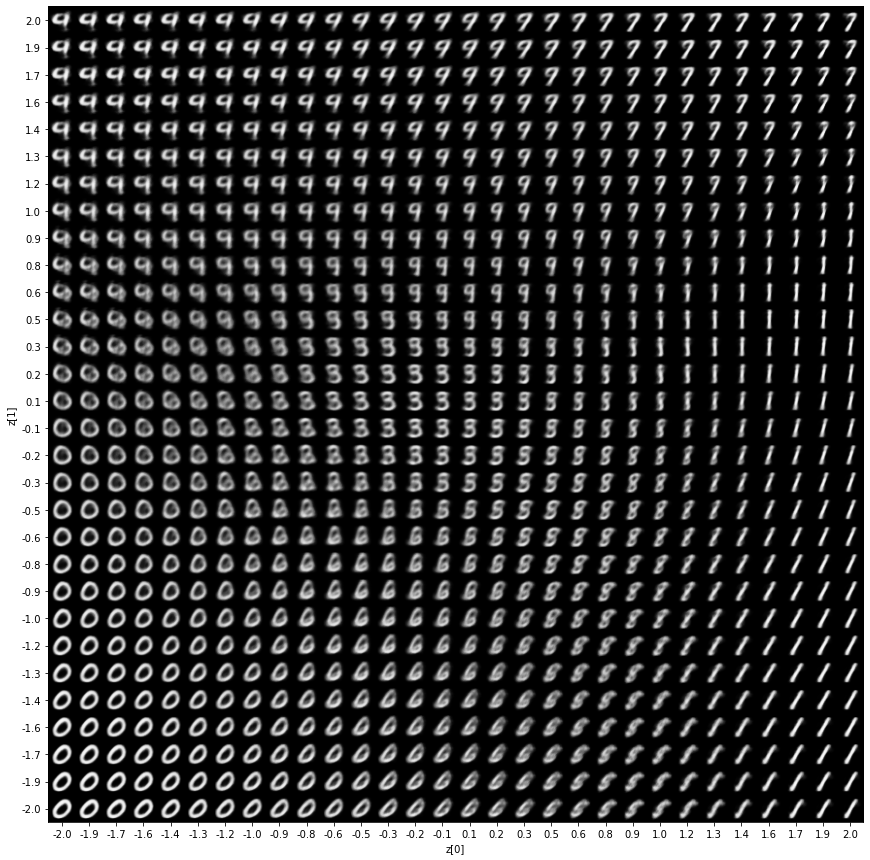

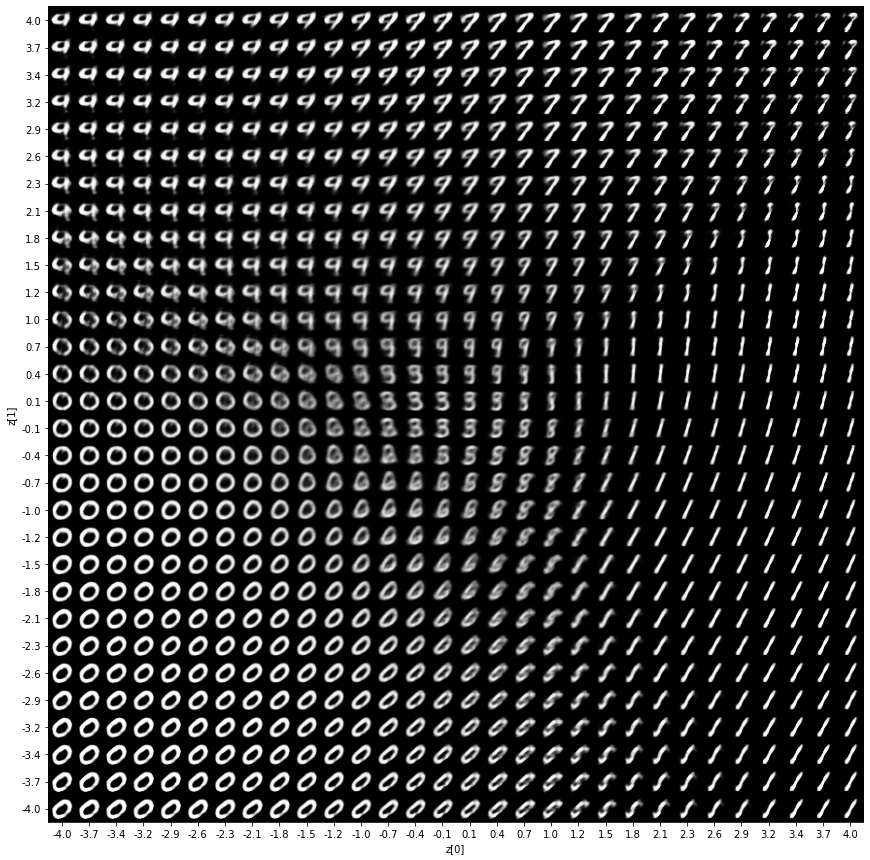

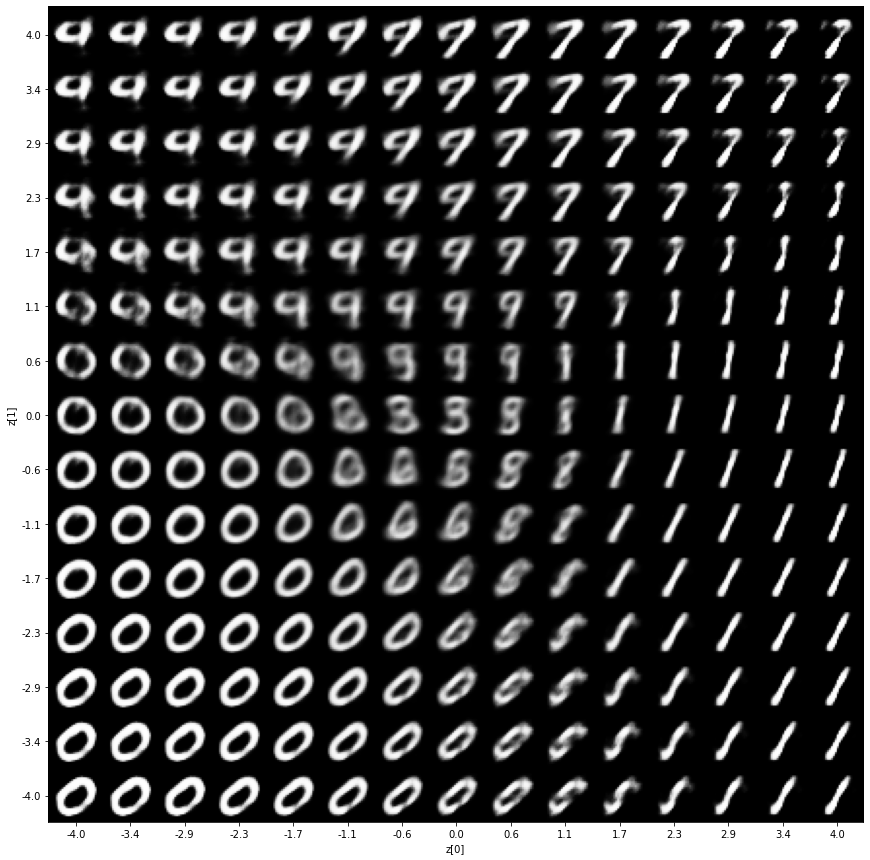

In [ ]:
plot_latent(encoder, decoder, 2.0, 30) # Model 8
plot_latent(encoder, decoder, 4.0, 30)
plot_latent(encoder, decoder, 4.0, 15)

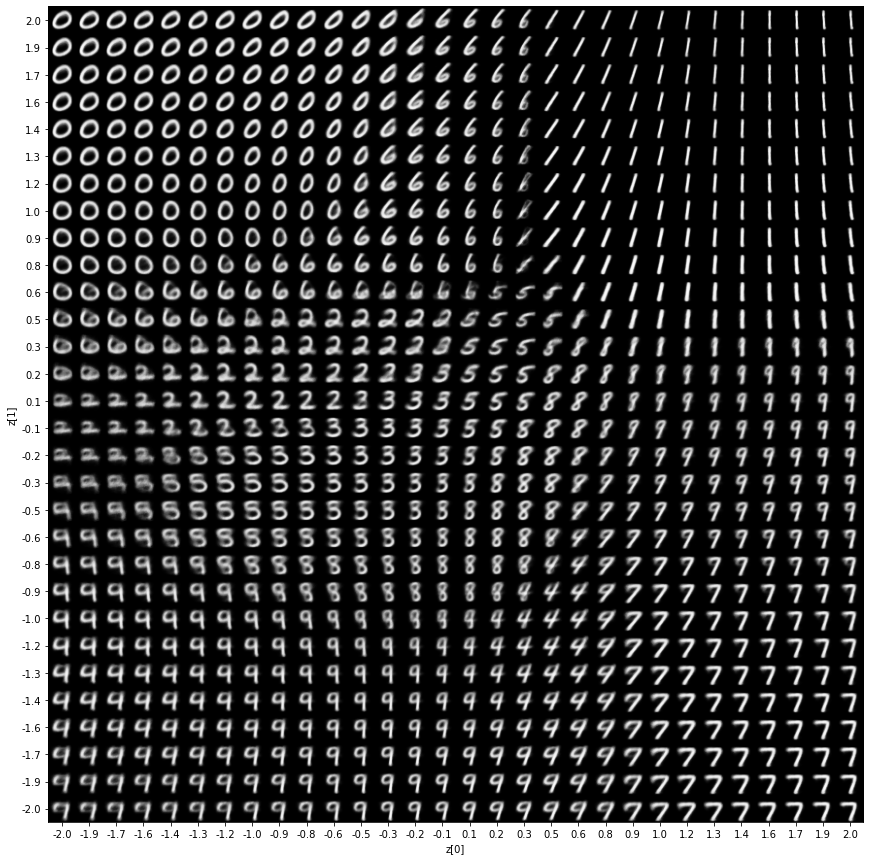

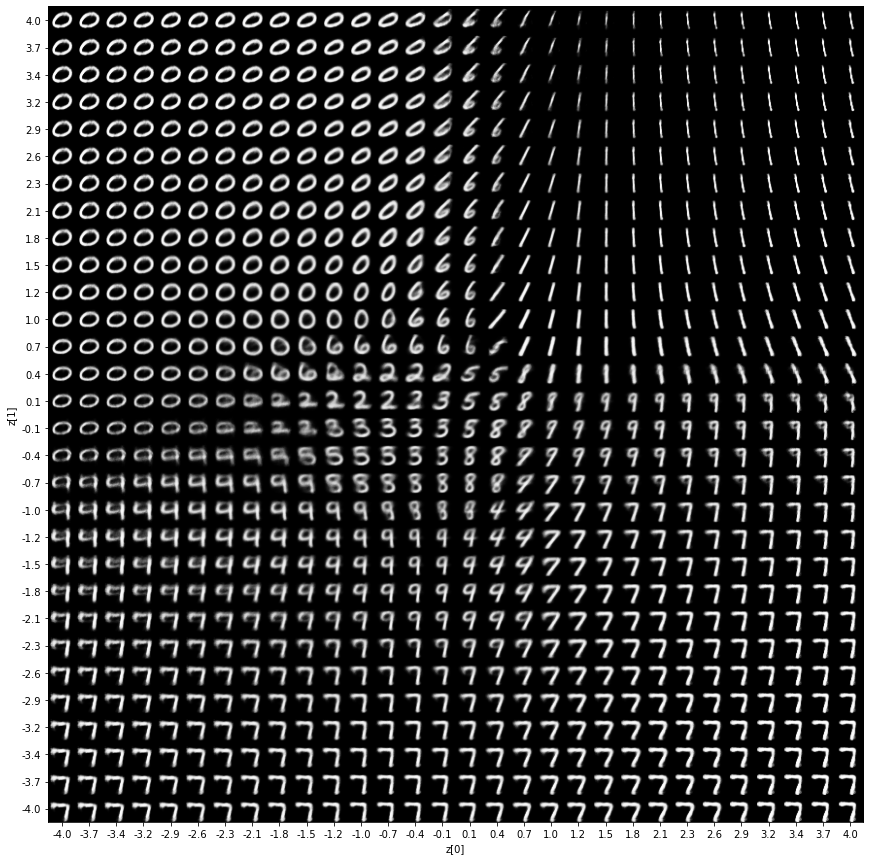

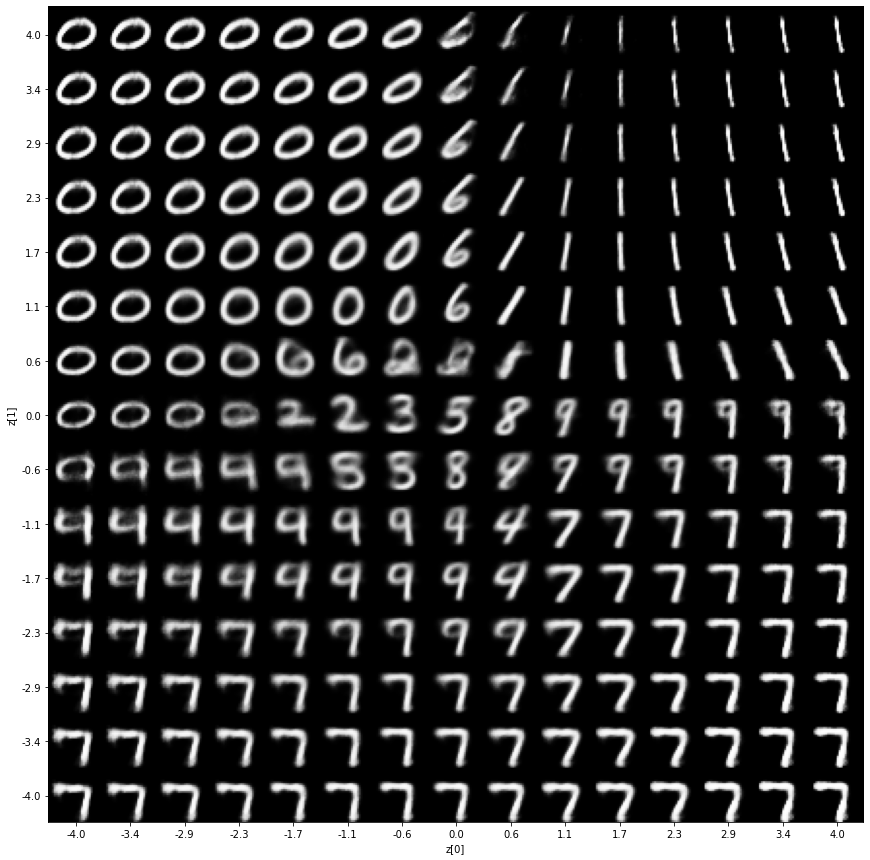

In [ ]:
plot_latent(encoder, decoder, 2.0, 30) # Model 9
plot_latent(encoder, decoder, 4.0, 30)
plot_latent(encoder, decoder, 4.0, 15)

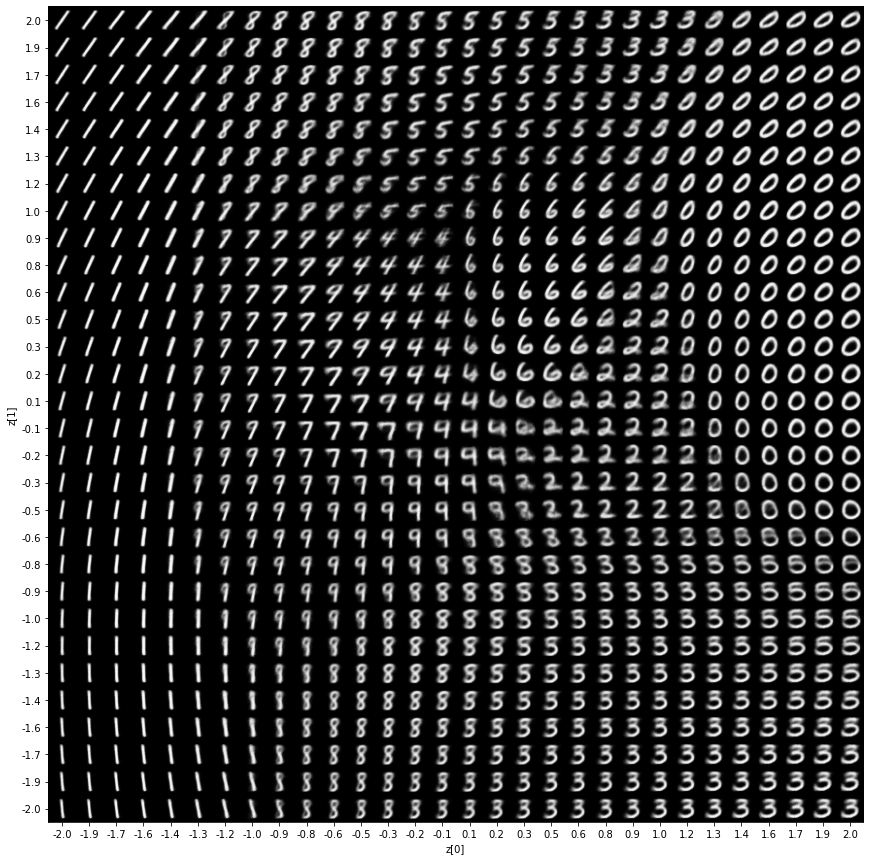

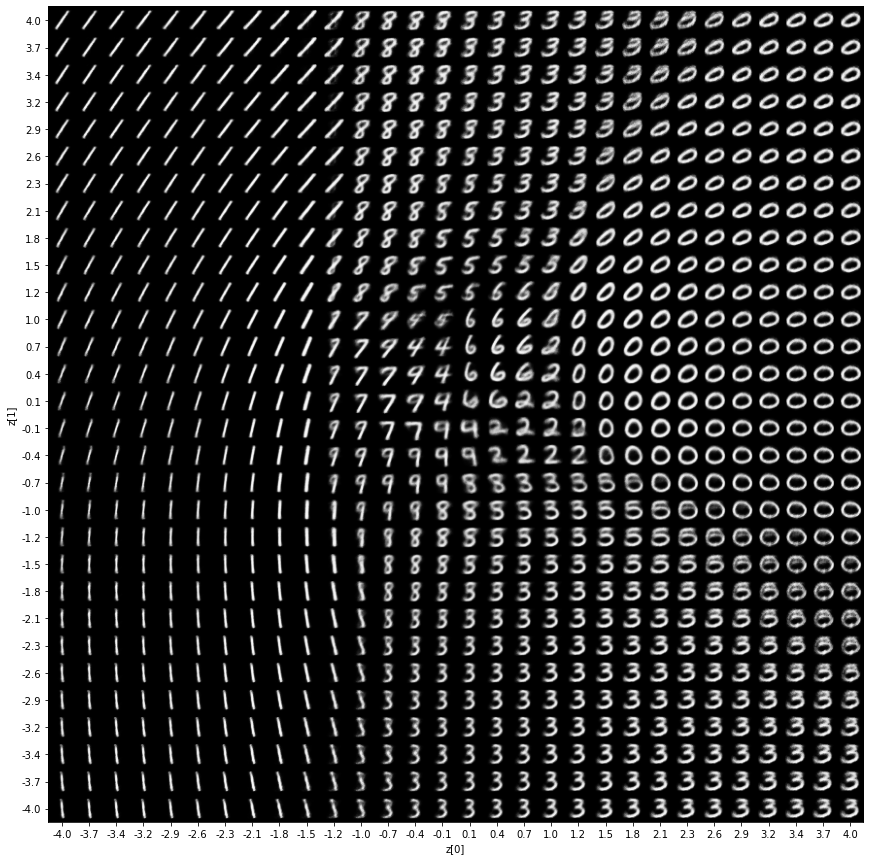

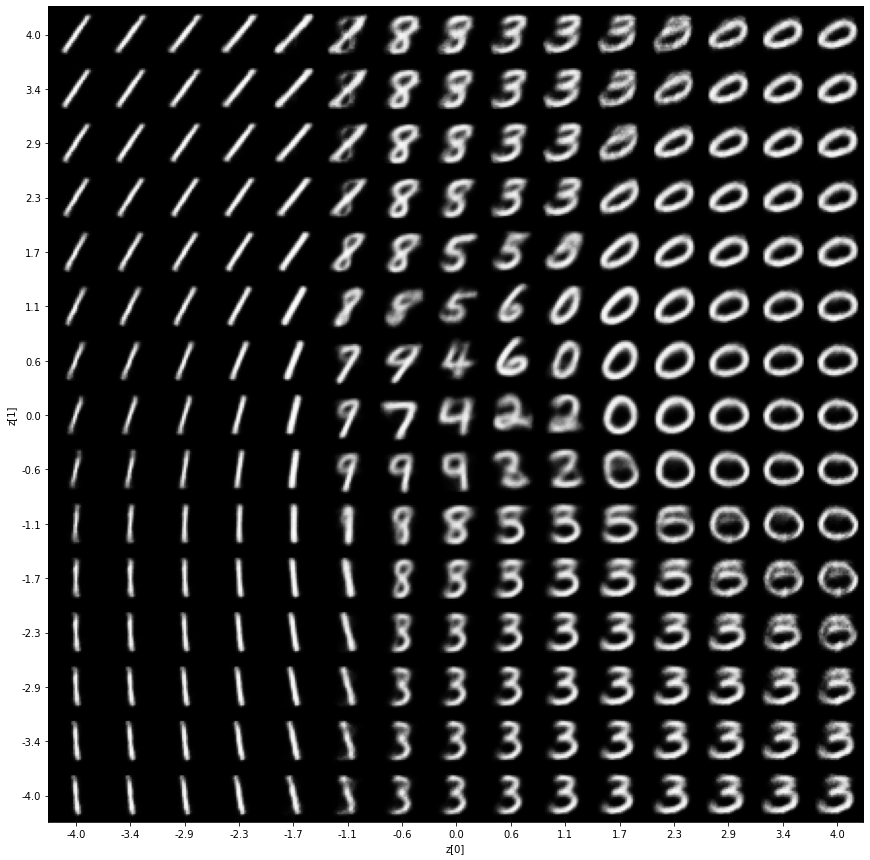

In [ ]:
plot_latent(encoder, decoder, 2.0, 30) # Model 10
plot_latent(encoder, decoder, 4.0, 30)
plot_latent(encoder, decoder, 4.0, 15)

Let's finally check how the various digits have been rapresented in the latent space by the VAE.

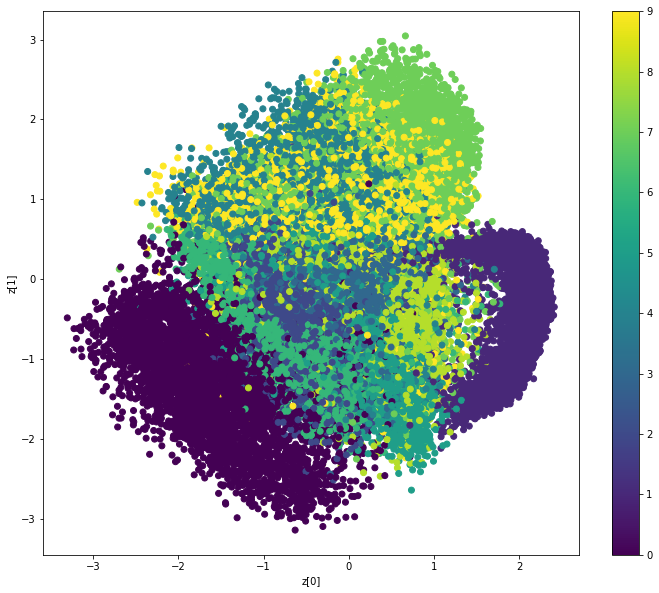

In [ ]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train) # Model 8

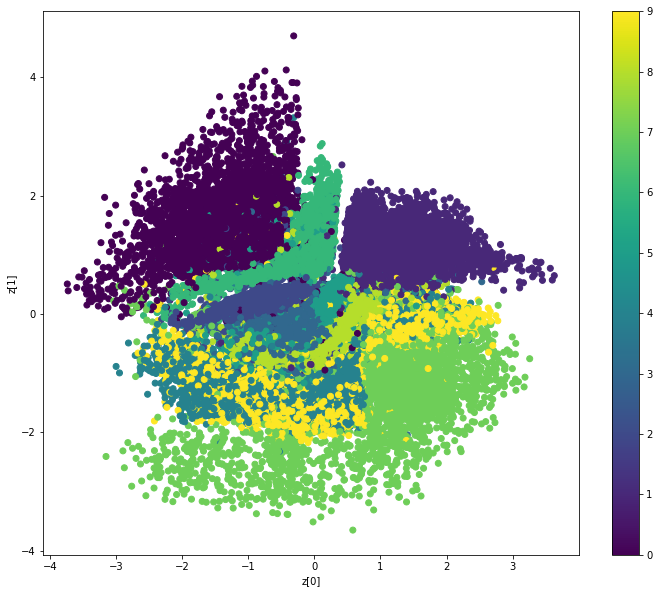

In [ ]:
plot_label_clusters(encoder, decoder, x_train, y_train) # Model 9

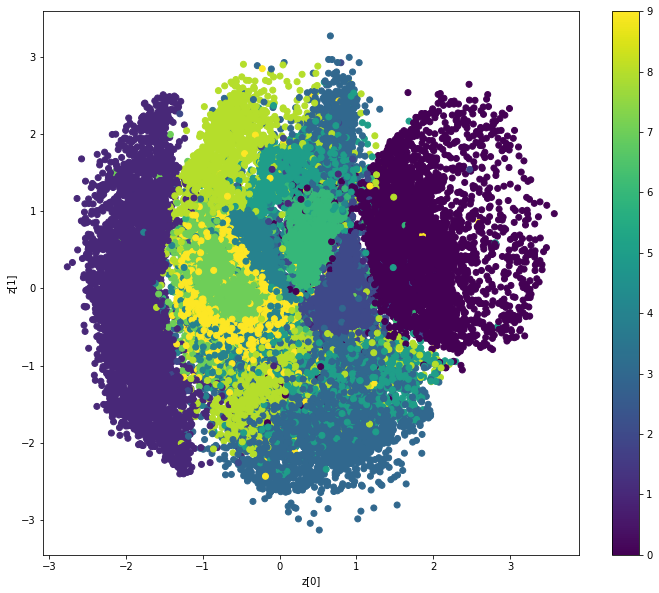

In [ ]:
plot_label_clusters(encoder, decoder, x_train, y_train) # Model 10

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

---
> **DISCUSSION OF THE PLOTS**
---


The deeper and more complex the network is, the lower the reconstruction loss is, but the higher the KL loss is. Each point in the plot represents a label instance of the trained set (label specified by its colour) and where they are on the 2D latent space when the encoder is applied. We can see that the lower the reconstruction loss and the higher the KL loss are, the more 'separated' the clusters are. With separated I mean they are more probable to belong to a small subset of the space. When the network is shallower and its layers are smaller, the instances are more spreaded over the latent space, and they overlap. 

In the samples grid we can see how smoothly does the samples vary when changing a bit the latent space (z). The reconstruction loss measures how close the outputs are to the inputs, while the KL loss measures how different the distribution is to a normal. So a lower KL loss means that the distribution obtained is better and therefore, the transition when moving in the latent space is smoother. 

We do not want the plot to have totally separated clusters, this would mean that some parts of the cluster would return unrealistic outputs when applying the decoder. We want all the space to be filled inbetween clusters so that the predicted distribution is continuous and every point in the latent space is well enough represented. Thus, it is a tradeoff between reconstruction loss and KL. 

---
> **MODEL PLOT COMPARING**
---

The plot from **MODEL 10** seems to give the best output in terms of reconstruction loss, with well enough defined clusters. But also when checking on the samples grid, all the points are well represented and the transition is smooth.

On the other hand, the plot from **MODEL 8** gives a messier distribution with a lot of overlapping. In the samples grid, we can see that the samples are very smooth when changing z, but not that well represented. 